In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X_train = np.load('X_train.npy')
X_valid = np.load('X_valid.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')

#X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) )
#X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) )
#y_train = y_train.reshape( (-1, 1) )
#y_test = y_test.reshape( (-1, 1) )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(161825, 120, 25) (161825,)
(5000, 120, 25) (5000,)
(10000, 120, 25) (10000,)


In [3]:
med = np.median(y_train)

def accuracy(pred, labels):
    return ( (pred > med) == (labels > med) ).astype(np.float64).mean()*100

In [9]:
batch_size = 64
time_per_cell = 4
skip_time = 2
time = 120
features_at_time = 25

num_nodes = [
    [time_per_cell*25, 64],
    [64, 64],
    [64, 32],
    [32, 1]
]

dropout = [0.5, 0.5, 0.5, 1.0]

num_unrollings = (time - time_per_cell) // skip_time

graph = tf.Graph()
with graph.as_default():
  
  # Inputs
  X_tr = tf.placeholder(tf.float32, shape=(batch_size, time, features_at_time))
  y_tr = tf.placeholder(tf.float32, shape=(batch_size, 1))
  X_te = tf.constant(X_test.astype(np.float32))
  X_val = tf.constant(X_valid.astype(np.float32))
    
  tr_inputs = []
  for i in range(num_unrollings):
    tr_inputs.append(tf.reshape( X_tr[:, skip_time*i:skip_time*i+time_per_cell], (batch_size, -1) ))
    
  val_inputs = []
  for i in range(num_unrollings):
    val_inputs.append(tf.reshape( X_val[:, skip_time*i:skip_time*i+time_per_cell], (X_val.shape[0], -1) ))
    
  te_inputs = []
  for i in range(num_unrollings):
    te_inputs.append(tf.reshape( X_te[:, skip_time*i:skip_time*i+time_per_cell], (X_test.shape[0], -1) ))

  # Variables
  w = []
  b = []
  for s in num_nodes:
    w.append(tf.Variable(tf.truncated_normal((s[0]+s[1], 4*s[1]), stddev=0.1)))
    b.append(tf.Variable(tf.zeros([4*s[1]])))
    
  w_dense = tf.Variable(tf.truncated_normal((num_unrollings, 1), stddev=0.1))
  b_dense = tf.Variable(tf.zeros(1))

  # Definition of the cell computation.
  # m = tf.matmul(tf.concat([i, o], axis=1), w) + b
  def lstm_cell(m, state):
    i, f, c, o = tf.split(m, num_or_size_splits=4, axis=1)
    input_gate = tf.sigmoid(i)
    forget_gate = tf.sigmoid(f)
    state = forget_gate * state + input_gate * tf.tanh(c)
    output_gate = tf.sigmoid(o)
    return output_gate * tf.tanh(state), state

  # Unrolling
  def unrolling(inputs, training=False):
    states = []
    outputs = []
    for i in range(len(w)):
      states.append(tf.zeros([inputs[0].get_shape()[0], num_nodes[i][1]]))
      outputs.append(tf.zeros([inputs[0].get_shape()[0], num_nodes[i][1]]))
    for j in range(num_unrollings):
      for i in range(len(w)):
        if i==0: inp = inputs[j]
        else:
            if training:
                inp = tf.nn.dropout(outputs[i-1], dropout[i-1])
            else:
                inp = outputs[i-1]
        m = tf.nn.xw_plus_b(tf.concat((inp, outputs[i]), axis=1), w[i], b[i])
        outputs[i], states[i] = lstm_cell(m, states[i])
    return outputs[-1]

  tr_outputs = unrolling(tr_inputs, True)
  tr_outputs2 = unrolling(tr_inputs)
  val_outputs = unrolling(val_inputs)
  te_outputs = unrolling(te_inputs)

  loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_tr, logits=tr_outputs))

  # Optimizer.
  #global_step = tf.Variable(0)
  #learning_rate = tf.train.exponential_decay(
  #  1.0, global_step, 5000, 0.1, staircase=True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  #gradients, v = zip(*optimizer.compute_gradients(loss))
  #gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  #optimizer = optimizer.apply_gradients(
  #  zip(gradients, v), global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  optimizer = tf.train.AdamOptimizer(1e-2).minimize(loss)

  # Predictions.
  tr_pred = tf.nn.sigmoid(tr_outputs2)
  val_pred = tf.nn.sigmoid(val_outputs)
  te_pred = tf.nn.sigmoid(te_outputs)

Initialized
Avg loss at step 0: 0.693314
Minibatch accuracy: 60.9%
Validation accuracy: 49.2%
Avg loss at step 50: 0.654382
Minibatch accuracy: 62.5%
Validation accuracy: 50.8%
Avg loss at step 100: 0.654606
Minibatch accuracy: 46.9%
Validation accuracy: 50.5%
Avg loss at step 150: 0.646147
Minibatch accuracy: 51.6%
Validation accuracy: 50.2%
Avg loss at step 200: 0.648521
Minibatch accuracy: 48.4%
Validation accuracy: 50.8%
Avg loss at step 250: 0.647476
Minibatch accuracy: 57.8%
Validation accuracy: 50.2%
Avg loss at step 300: 0.644453
Minibatch accuracy: 48.4%
Validation accuracy: 50.8%
Avg loss at step 350: 0.650716
Minibatch accuracy: 53.1%
Validation accuracy: 50.1%
Avg loss at step 400: 0.650623
Minibatch accuracy: 56.2%
Validation accuracy: 50.0%
Avg loss at step 450: 0.652235
Minibatch accuracy: 53.1%
Validation accuracy: 50.5%
Avg loss at step 500: 0.648076
Minibatch accuracy: 50.0%
Validation accuracy: 50.3%
Avg loss at step 550: 0.643708
Minibatch accuracy: 51.6%
Validation

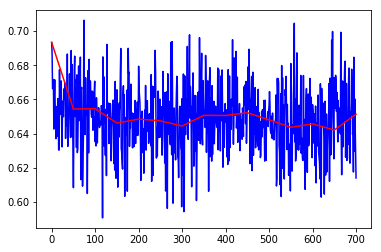

In [10]:
num_steps = 701

with tf.Session(graph=graph) as session:
  losses=[]
  avg=[]
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :]
    batch_labels = y_train[offset:(offset + batch_size)].reshape((-1, 1))
    feed_dict = {X_tr : batch_data, y_tr : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tr_pred], feed_dict=feed_dict)
    losses.append(l)
    if (step % 50 == 0):
      avg.append(sum(losses[-50:])/len(losses[-50:]))
      print('Avg loss at step %d: %f' % (step, avg[-1]))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(val_pred.eval(), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(te_pred.eval(), y_test))
  plt.plot(range(num_steps), losses, 'b', np.array(range(len(avg)))*50, avg, 'r')
  plt.show()